v2: REMOVED high. low and open. ONLY close/last.
v3: using batch and epoch as they are supposed to, cycling through the whole dataset first.
0 = close/last
objective: guess the next closing value in the next day
if days is set to n, this means that n-1 values are inputted into neural network while 1 is used for the test. This is to prevent an error I encountered.

In [121]:
import random
def random_exhaust(batch_size):
    

    batch_pile = []
    for batch in range(batch_size):
        batch_pile.append(batch)
    for batch in range(batch_size):
        randbatch = batch_pile[random.randrange(0, len(batch_pile))]


        batch_pile.remove(randbatch)
        print(randbatch)
random_exhaust(10)

1
5
6
9
8
2
4
0
7
3


In [13]:
import torch
from torch import nn
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import csv
import numpy as np
import tensorflow as tf
import math
import time


with open(r'C:\Users\user\Documents\road to qm\machine learning\pytorch\stock market\NVDA_10.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
data = np.array(data)
#lookback_range = 1000
#data = data[:lookback_range,:]
num_days = data.shape[0]-1
data = np.delete(data,0,axis = 0) #clears first row

stock_data = np.delete(data,0, axis = 1)
stock_data = np.delete(stock_data,1, axis = 1) #gets rid of date and volume

for i in range(len(stock_data)):
    for j in range(len(stock_data[i])):
        if stock_data[i][j][0] == '$':
             
            stock_data[i][j] = stock_data[i][j][1:]
stock_data = np.array([list( map(float,i) ) for i in stock_data])
print(stock_data)
#print(num_days)
#print(data)
#print(data.shape)
def normalize(n):
    n = 1/(1+np.exp(-n))
    return n
def stock_matrix_generator(data, stock_data, days, batch_size):  #generates a matrix of stock prices with non-repeating batches
     #deletes the top row
    upper_range = np.random.randint(num_days - days, num_days) #gives index between  num_days and num_Days - days as a starting point.
    #this selects the starting point for the batch to cycle over
    stock_matrix = []
    next_day_vector = []
    date_array = []
    lower_range = upper_range - days
    #closing value the next day - this will be our test data
    
    
   
    #slicing data into small chunks and removing unneccessary rows and columns
    for i in range(batch_size):
       
        
        
            
            
        date = data[lower_range-(i*days)-1][0]
        date_array.append(date)
        

        next_price = stock_data[lower_range-(i*days)-1][0]
        #print('next day row')
        #print(next_day_row)
       
        #print('next day matrix')
        #print(next_day_matrix)
        stock_array = stock_data[lower_range-(i*days):upper_range-(i*days)-1,:]
        #stock_array = stock_array[:,1] #only need closing price

        #now to get rid of the dollar sign and change all into floats

        #now turn into a single lined vector
        stock_vector = stock_array.reshape((days-1)*4,1)
        
        stock_matrix.append(stock_vector)
        #insert into the matrix in a random order (maybe better than just append)
        next_day_vector.append(next_price)
    stock_matrix = np.array(stock_matrix)
   
    next_day_vector = np.array(next_day_vector)

    stock_matrix = torch.from_numpy(stock_matrix)
    stock_matrix = stock_matrix.reshape(batch_size, -1)
    next_day_vector = torch.from_numpy(next_day_vector)
    date_array = np.array(date_array)

    return stock_matrix, next_day_vector, date_array

[[129.37   125.86   129.6    125.22  ]
 [123.74   130.02   130.75   123.1   ]
 [128.5    127.315  129.35   126.66  ]
 ...
 [  0.4848   0.4798   0.4858   0.4783]
 [  0.4808   0.4832   0.4869   0.48  ]
 [  0.4864   0.479    0.4872   0.4773]]


In [14]:
#initializing
days = 65
batch_size = math.floor(num_days/days)-1
print(batch_size)

stock_matrix, next_day_vector, date_array = stock_matrix_generator(data,stock_data, days, batch_size)

print(stock_matrix.shape)
print(next_day_vector[123])
print(date[123])
print(stock_matrix[123])

37
torch.Size([37, 256])


IndexError: index 123 is out of bounds for dimension 0 with size 37

Epoch 0
At 0 step, loss is 454.8807678222656
At 10 step, loss is 256.2681884765625
At 20 step, loss is 108.19680786132812
At 30 step, loss is 21.049762725830078
Epoch 1
At 0 step, loss is 9.537485122680664
At 10 step, loss is 9.766340255737305
At 20 step, loss is 9.398380279541016
At 30 step, loss is 9.079607009887695
Epoch 2
At 0 step, loss is 6.537028789520264
At 10 step, loss is 6.2154927253723145
At 20 step, loss is 5.868023872375488
At 30 step, loss is 5.506592273712158
Epoch 3
At 0 step, loss is 10.71475887298584
At 10 step, loss is 8.732998847961426
At 20 step, loss is 6.660735130310059
At 30 step, loss is 4.728180408477783
Epoch 4
At 0 step, loss is 4.695137023925781
At 10 step, loss is 2.809730291366577
At 20 step, loss is 2.602386236190796
At 30 step, loss is 2.3612265586853027
Epoch 5
At 0 step, loss is 6.5103888511657715
At 10 step, loss is 2.855766773223877
At 20 step, loss is 2.6912026405334473
At 30 step, loss is 2.2457358837127686
Epoch 6
At 0 step, loss is 7.4094557762

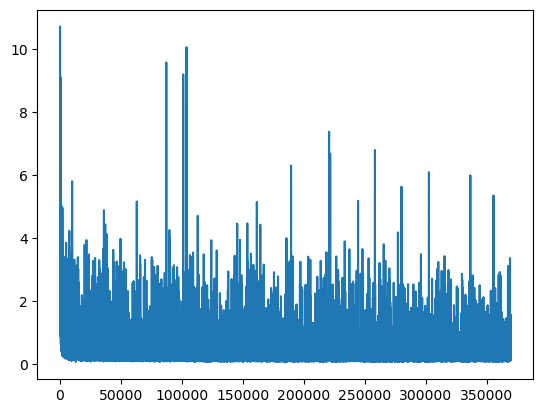

In [17]:
#hyperparameters:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_array =[]
days = 65 #control number of days available to the neural network

batch_size = math.floor(num_days/days) - 1 #in huge datasets it is customary to use batch size and updating parameters each batch until it covers the whole 
#dataset each epoch. It is also customary to use powers of 2 for the batch size.

learning_rate = 0.001

n_epoch = 10000 #an epoch ends when the whole training set is covered.

input_size = (days - 1)*4 #I hate tensors

batch_pile = []

dimensions = {"L0": input_size, "L1": 8, "L2": 4, "L3":2, "L4":1} #number of nodes in each layer, L4 is the output. 10 IS FIXED
class NeuralNetwork(nn.Module):
    def __init__(self, dimensions):
        super(NeuralNetwork, self).__init__()
        self.L1 = nn.Linear(dimensions['L0'], dimensions['L1'])
        self.relu = nn.ReLU()
        self.L2 = nn.Linear(dimensions['L1'], dimensions['L2'])
        self.L3 = nn.Linear(dimensions['L2'], dimensions['L3'])
        self.L4 = nn.Linear(dimensions['L3'], dimensions['L4'])
    def forward(self, x): #x is the input
        #3 layers, each with relu except the last layer.
        x = self.L1(x)
        x = self.relu(x)
        x = self.L2(x)
        x = self.relu(x)
        x = self.L3(x)
        x= self.relu(x)
        y_predict = self.L4(x)
        return y_predict
model = NeuralNetwork(dimensions)

lossf = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
for epoch in range(n_epoch):
    print('Epoch ' + str(epoch))
    stock_matrix, next_day_vector, date_array = stock_matrix_generator(data, stock_data, days, batch_size)
    
    #next_day_vector is a tensor, stock matrix is not.
    
    batch_pile = []

        
    for batch in range(batch_size):
        

        stock_tensor = stock_matrix.float()  #transpose because pytorch is shit
        #actual = torch.from_numpy(np.array([float(next_day_matrix[1][1:])])).float()
        next_day_vector = next_day_vector.float()
        #using cuda
        stock_tensor.to(device)
        next_day_vector.to(device)
        
        y_predict = model(stock_tensor) #forward prop
        
        loss = lossf(y_predict.reshape(-1), next_day_vector.T)
        loss_array.append(loss)
        loss.backward() #backprop

        optimizer.step() #update parameters
        optimizer.zero_grad() #resets the gradients
        if batch % 10 == 0:
            print(f'At {batch} step, loss is {loss}')
print(f'At the last step, loss is {loss}')
with torch.no_grad():
    ignore = 100
    plt.plot(np.linspace(0,batch_size*n_epoch-1-ignore,num=batch_size*n_epoch-ignore), loss_array[ignore:])
    #[ignore:] to try to omit the very high init values
    print(min(loss_array))

In [146]:
print(min(loss_array))


tensor(0.0698, grad_fn=<MseLossBackward0>)


In [30]:
#what will happen tomorrow?
with torch.no_grad():
    days_back = 2
    stock_matrix = stock_data[days_back:(days-1)+days_back].reshape(1,4*(days-1))
    stock_tensor = torch.from_numpy(stock_matrix).float()
    prediction = model(stock_tensor)
    print(stock_matrix)
    print('prediction: ')
    print(prediction)

[[128.5    127.315  129.35   126.66   127.25   128.4    129.88   125.89
  130.     124.28   130.     123.42   124.58   121.94   125.     121.18
  122.86   118.76   123.24   117.47   118.08   118.53   118.6    114.07
  116.14   112.44   116.23   111.58   109.02   106.32   111.07   106.26
  104.75   105.64   106.6    103.43   104.97   102.     105.5     97.52
   98.91   107.81   108.8     98.69   104.25   103.84   107.71   100.55
  100.45    92.06   103.41    90.69   107.27   103.76   108.72   101.37
  109.21   117.53   120.16   106.8104 117.02   112.9    118.34   110.88
  103.73   111.52   111.99   102.54   111.59   113.69   116.28   111.3
  113.06   116.19   116.2    111.58   112.28   113.04   116.63   106.3
  114.25   119.17   119.95   113.44   122.59   122.78   124.69   122.1
  123.54   120.35   124.07   119.86   117.93   120.35   121.6    117.37
  121.09   121.85   122.4    116.56   117.99   121.35   121.85   116.72
  126.36   128.44   129.04   124.58   128.44   130.56   131.39   12

24
Predicted on 04/28/2021 : 
[15.595304]
Actual was: 
15.2768
[2.0848827]%
previous price: 15.3818
Directions disagree
33
Predicted on 06/15/2023 : 
[42.730568]
Actual was: 
42.653
[0.18185838]%
previous price: 42.997
Price will decrease as predicted
9
Predicted on 04/27/2017 : 
[2.6604013]
Actual was: 
2.641
[0.7346199]%
previous price: 2.6005
Price will increase as predicted
11
Predicted on 01/02/2018 : 
[5.036492]
Actual was: 
4.9838
[1.0572643]%
previous price: 4.8375
Price will increase as predicted
27
Predicted on 12/31/2021 : 
[29.880766]
Actual was: 
29.411
[1.5972481]%
previous price: 29.586
Directions disagree
25
Predicted on 08/11/2021 : 
[20.57653]
Actual was: 
19.699
[4.4546986]%
previous price: 19.936
Directions disagree
10
Predicted on 08/15/2017 : 
[4.2552667]
Actual was: 
4.1745
[1.934763]%
previous price: 4.21
Directions disagree
25
Predicted on 06/18/2021 : 
[19.044239]
Actual was: 
18.6387
[2.1757877]%
previous price: 18.6573
Directions disagree
7
Predicted on 10/2

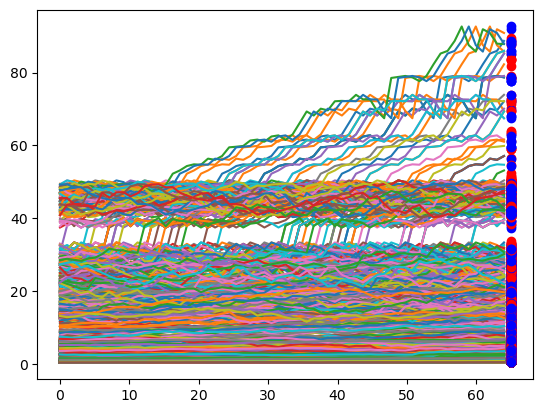

In [19]:

with torch.no_grad():
    points = 0
    no_tests = 2000
    for test in range(no_tests):

        #1 point if trend is correct, 1 point if within 1%
        randnum = np.random.randint(0, batch_size-1)
        print(randnum)
        stock_matrix, next_day_vector, date_array = stock_matrix_generator(data,stock_data, days, batch_size)
        stock_tensor = stock_matrix[randnum].float() 
        
        predicted = model(stock_tensor)
        predicted = predicted.numpy()
        

        test_actual = next_day_vector.T[randnum]
        test_actual = test_actual.numpy()
        day = date_array[randnum]
        
        print('Predicted on ' + day + ' : ')
        print(predicted)
        print('Actual was: ')
        print(test_actual)
        diff = 100*((test_actual - predicted)**2)**0.5/test_actual 
        if diff < 1:
            points += 1
        print(str(diff) + '%')
        prev_price = stock_matrix[randnum][0].numpy()
        print('previous price: ' + str(prev_price))
        if prev_price > test_actual:
            if prev_price > predicted:
                print('Price will decrease as predicted')
                points += 1
            else:
                print('Directions disagree')
        else:
            if prev_price < predicted:
                print('Price will increase as predicted')
                points += 1
            else:
                print('Directions disagree')
        
        #to plot the values:
        stock_vector = stock_matrix[randnum].numpy()
        stock_vector = stock_vector.reshape(-1,4)[:,0]

        stock_vector = stock_vector[::-1]
        plt.plot(np.linspace(0,days-1,num=days-1),  stock_vector)
        plt.plot(days,predicted, 'ro', label = 'predicted')
        plt.plot(days,test_actual, 'bo')
    print('points: ' + str(points))
    score = points/(no_tests*2)  #no. of possible points
    print('score: ' + str(score))

    
    

In [20]:
#saving the model
def save_and_write_to_archive(file_name, loss, learning_rate, days, n_epoch, dataset, score, comments):
    file_path = "{}/{}".format("C:/Users/user/Documents/road to qm/machine learning/pytorch/stock market/models/", file_name)
    torch.save(model.state_dict(), file_path)
    archive = [file_name, loss, learning_rate, days, n_epoch, dataset, score, comments]
    with open(r'C:\Users\user\Documents\road to qm\machine learning\pytorch\stock market\models\archive.csv','a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerow(archive)

In [21]:

timestr = time.strftime("%Y%m%d-%H%M%S")
save_and_write_to_archive(timestr, loss, learning_rate, days, n_epoch, 'NVDA', score, "8 minutes for this?")